# Implementation Startegy
- Configurations
- Visualize Data
- Audio
- Video

- Implementating FER
    1. Extract Frames from videos
    2. Detect Face
    3. Extract Features
    4. Classify Features


Important Links to understand Audio and Video Data
https://devopedia.org/audio-feature-extraction

## Imports and Variables

In [8]:
import os
import sys
import zipfile
import cv2
import numpy as np
import matplotlib.pyplot as plt
import librosa
%matplotlib inline
import librosa.display
from IPython.display import Audio
import tensorflow as tf
from matplotlib.pyplot import specgram
import pandas as pd
from sklearn.metrics import confusion_matrix, accuracy_score
import IPython.display as ipd  # To play sound in the notebook
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.preprocessing import LabelEncoder
import keras
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, AveragePooling1D
from keras.layers import Input, Flatten, Dropout, Activation, BatchNormalization, Dense
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.optimizers import SGD
from keras.regularizers import l2
import seaborn as sns
from keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report

In [9]:
import moviepy.editor as mp
import soundfile as sf

In [2]:
#variables 
dirname = os.getcwd()
datasetdir  = os.path.join(dirname,"dataset")
audio = os.path.join(datasetdir, "audio")
video = os.path.join(datasetdir, "video")
av = os.path.join(datasetdir, "av")

filedesc = {
    "Modality": {"01": "full-AV", "02" : "video-only", "03" : "audio-only"},
    "Emotion": {"01" : "neutral", "02" : "calm", "03" : "happy", "04" : "sad", "05" : "angry", "06" : "fearful", "07" : "disgust", "08" : "surprised"},
    "Emotional intensity": {"01" : "normal", "02" : "strong"}, 
    "Statement": {"01" : "Kids are talking by the door", "02" : "Dogs are sitting by the door"}}
print(datasetdir)

l:\Drive - UMass\Side hustles\IIITD Coding challenmge\audio-video\dataset


## Configurations

In [ ]:
#run only when using colab
from google.colab import drive
drive.mount('/content/drive')

In [6]:
def create_dataset():
  datadir = os.path.join(dirname,"data")
  filelist = os.listdir(datadir)
  dir  = os.path.join(dirname,"dataset")
  videodir = os.path.join(dir,"video")
  if ~os.path.isdir(dir):
    os.mkdir(dir)
    os.mkdir(videodir)

  for f in filelist:
    with zipfile.ZipFile(os.path.join(datadir, f), 'r') as zip_ref:
      zip_ref.extractall(videodir)

# create_dataset() #run first time only

In [ ]:
#split data into audio and visual
import shutil
# Convert all AV files to audio only files for the SER model
def create_audio_files():
  if not os.path.isdir(audio):
      os.mkdir(audio)
  if not os.path.isdir(video):
      os.mkdir(video)
  if not os.path.isdir(av):
      os.mkdir(av)
  folders = os.listdir(video)
  for f in folders:
    cur_dir = os.path.join(video, f)
    files = os.listdir(cur_dir)
    files = [fi for fi in files if fi.startswith("01")]
    new_dir = os.path.join(audio, f)
    new_av = os.path.join(av, f)
    if not os.path.isdir(new_dir):
        os.mkdir(new_dir)
    if not os.path.isdir(new_av):
        os.mkdir(new_av)
    for fl in files:
        shutil.move(os.path.join(cur_dir, fl), os.path.join(new_av, fl))
        clip = mp.VideoFileClip(os.path.join(new_av, fl))
        clip.audio.write_audiofile(os.path.join(new_dir, fl.replace("mp4", "wav")))
      

create_audio_files()

# Audio
- Visualize Data
- Feature Extraction and Generation
- Data Pre-Processing
- Basline Model using SVM
- Data Augmentation
- Final Model

## Visualize Data

In [ ]:
# LOAD IN FILE AND DISPLAY PLOT

fig, ax= plt.subplots(4, 1)
for i in range(4):
    clip = mp.VideoFileClip(os.path.join(os.getcwd(),f"dataset/Actor_01/01-01-0{i+1}-01-01-01-01.mp4"))
    clip.audio.write_audiofile(os.path.join(os.getcwd(),"my_result.wav"))
    x, sr = librosa.load(os.path.join(os.getcwd(),"my_result.wav"))
    librosa.display.waveshow(x, sr=sr, ax=ax[i])
    fig.suptitle('Waveplot for multiple emotions of Actor 1')

fig.show()
plt.savefig('Waveplot_sample.png')

# PLAY AUDIO FILE
# Audio(data=x, rate=sr)

Based on above waves, I evaluated some of the feature extraction methods for audio signals based on the amplitude and curves and decided to use the **Mel Spectrograms**. Some of the features i evaluated were:
1. Amplitude Envelope --> considers the maximum amplitudes value among all samples in each frame (prefered when understanding loudness as its sensitive to outliers which we need to consider in current scenario)
2. Zero-Crossing Rate --> Number of times a waveform crosses the horizontal time axis usually used for pitch realted features
3. Root Mean Square Energy -- > indicator for loudness but is not sensitive to outliers (prefered for segmentation tasks)
4. Mel Spectrograms -->  converting fequency to log mel scale including both time and frequency information
5. Mel-Frequency Cepstral Coefficients -- > a calculation of spectrum belonging to neither time or frquency domain but a co-efficient calculated based on both 

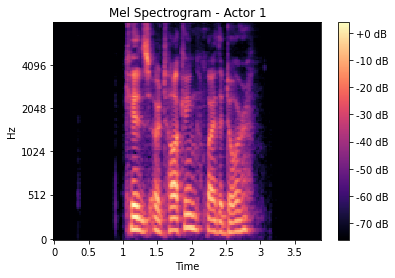

In [32]:
# Log Mel Spectograms 
spectrogram = librosa.feature.melspectrogram(y=x, sr=sr, n_mels=128,fmax=8000) 
spectrogram = librosa.power_to_db(spectrogram)
librosa.display.specshow(spectrogram, y_axis='mel', fmax=8000, x_axis='time');
plt.title('Mel Spectrogram - Actor 1')
plt.savefig('MelSpec_Actor1.png')
plt.colorbar(format='%+2.0f dB');


# mfcc = librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13)
# mfcc=np.mean(mfcc,axis=0)
    

#  zero-crossing-rate
#     zcr = librosa.feature.zero_crossing_rate(y=X)
#     zcr = np.mean(zcr, axis= 0)

## Feature Extraction and Generation

In [41]:
# get log mel spectrogram values
def get_mel_spectogram(file_path, augment):
    X, sr = librosa.load(file_path, res_type='kaiser_fast',duration=3,sr=44100,offset=0.5)

    if augment:
        X = noise(X)
    spectrogram = librosa.feature.melspectrogram(y=X, sr=sr, n_mels=128,fmax=8000) 
    spec = librosa.power_to_db(spectrogram)
    #average the spectrogram values
    log_spectrogram = np.mean(spec, axis = 0)
    return log_spectrogram 

In [38]:
#Audio
# # Function to extract features and labels and create Dataframe
def create_df(augment):
    rows = []
    spectogram = []
    actors = os.listdir(audio)
    for a in actors:
        cur_dir = os.path.join(audio,a)
        files = os.listdir(cur_dir) 
        for f in files: # files in Actor folder
            part = f.split('.')[0].split('-') 
            file_path = os.path.join(cur_dir, f)
            rows.append([filedesc["Emotion"][part[2]], #emotion
            int(part[3]), #intensity 1=normal 2 strong
            # filedesc["Statement"][part[4]], #statement
            1 if int(part[6])%2 == 0 else "0", #gender female =1, male=0
            int(part[6])]) #actor
            spectogram.append(get_mel_spectogram(file_path, augment)) #mel spectogram


    #create dataframe
    cols = ["emotion", "emotional_intensity", "gender", "actor"] # "statement"
    df = pd.DataFrame(rows, columns=cols)
    spec = pd.DataFrame(spectogram)
    return pd.concat([df, spec], axis=1).fillna(0)


audio_df = create_df("")

In [13]:
audio_df.head(5)

,emotion,emotional_intensity,gender,actor,0,1,2,3,4,5,...,249,250,251,252,253,254,255,256,257,258
0,neutral,1,0,1,-76.311501,-76.311501,-76.311501,-76.311501,-76.311501,-76.311501,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,neutral,1,0,1,-75.654289,-75.300285,-74.655289,-75.086594,-75.631195,-75.593407,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,neutral,1,0,1,-75.190407,-75.190407,-75.190407,-75.190407,-75.190407,-75.190407,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,neutral,1,0,1,-75.255531,-75.255531,-75.255531,-75.255531,-75.255531,-75.255531,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,calm,1,0,1,-80.150398,-80.150398,-80.150398,-80.150398,-80.150398,-80.150398,...,-80.150398,-80.150398,-80.150398,-80.150398,-80.150398,-80.150398,-80.150398,-80.150398,-80.150398,-80.150398


## Data Pre-processing

1. Train, test split the data - splitting based on authors

In [26]:

mask = audio_df["actor"]<=20
audio_df.drop(columns=["gender"], inplace=True)
train = audio_df[mask]
test = audio_df[~mask]

X_train, y_train = train.iloc[:,1:], train["emotion"]
X_test, y_test= test.iloc[:,1:], test["emotion"]

X_train.head(2)

,emotional_intensity,actor,0,1,2,3,4,5,6,7,...,249,250,251,252,253,254,255,256,257,258
0,1,1,-76.311501,-76.311501,-76.311501,-76.311501,-76.311501,-76.311501,-76.311501,-76.311501,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,1,-75.654289,-75.300285,-74.655289,-75.086594,-75.631195,-75.593407,-74.705154,-74.950005,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


2. Normalizing Data

In [27]:
X_train = (X_train - X_train.min())/(X_train.max() - X_train.min())
X_test = (X_test - X_test.min())/(X_test.max() - X_test.min())
X_train.head(5)

,emotional_intensity,actor,0,1,2,3,4,5,6,7,...,249,250,251,252,253,254,255,256,257,258
0,0.0,0.0,0.288527,0.260028,0.263398,0.265641,0.265979,0.266956,0.272420,0.275295,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,0.0,0.0,0.298275,0.275417,0.288928,0.284684,0.276569,0.278175,0.298030,0.297231,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
2,0.0,0.0,0.305156,0.277089,0.280679,0.283071,0.283430,0.284471,0.290294,0.293357,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
3,0.0,0.0,0.304190,0.276098,0.279676,0.282058,0.282417,0.283454,0.289255,0.292308,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
4,0.0,0.0,0.231586,0.201608,0.204220,0.205960,0.206222,0.206979,0.211215,0.213445,...,0.141844,0.141844,0.141844,0.141844,0.141844,0.141844,0.141844,0.141844,0.141844,0.141844


3. Encode the labels 

In [28]:
#One hot encoding for labels
lb = LabelEncoder()
y_train_en = to_categorical(lb.fit_transform(y_train))
y_test_en = to_categorical(lb.fit_transform(y_test))

print(y_test_en[0:5])

[[0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0.]]


## Baseline Model - Using SVM

In [37]:
from sklearn.svm import NuSVC
from sklearn.metrics import accuracy_score 
svclassifier = NuSVC()
svclassifier.fit(X_train, y_train)

y_pred = svclassifier.predict(X_test)
print(confusion_matrix(y_test,y_pred))
print("Accuracy: " + str(accuracy_score(y_test,y_pred)))

[[21  0  1  4  0  0  2  4]
 [ 0 12  8  0  0  2 10  0]
 [ 4  0 19  0  1  3  2  3]
 [10  0  3  7  1  1  0 10]
 [ 8  1  0  5  3  4  5  6]
 [ 0  3  2  0  1  5  5  0]
 [ 1  4 12  0  0  4 10  1]
 [ 2  0  0  0  3  1  0 26]]
Accuracy: 0.42916666666666664


## Data Augmentation

Adding noise to audio files

In [39]:
def noise(y):
    noise_amp = 0.05*np.random.uniform()*np.amax(y)   
    y = y.astype('float64') + noise_amp * np.random.normal(size=y.shape[0])
    return y

In [42]:
aug_audio_df = create_df(True)

Using a pre-trained hugging face model to detect emotions and fine tune on current data

In [ ]:
!pip install huggingface_hub==0.1
!pip install torchaudio
!pip install librosa
!pip install jiwer

In [ ]:
!git lfs install
!git clone https://huggingface.co/ehcalabres/wav2vec2-lg-xlsr-en-speech-emotion-recognition
# if you want to clone without large files – just their pointers
# prepend your git clone with the following env var:
GIT_LFS_SKIP_SMUDGE=1

In [52]:
!pip install -q transformers

You should consider upgrading via the 'l:\drive - umass\side hustles\iiitd coding challenmge\audio-video\ve\scripts\python.exe -m pip install --upgrade pip' command.


In [3]:
import torch 
from transformers import Wav2Vec2ForCTC, Wav2Vec2Tokenizer

tokenizer = Wav2Vec2Tokenizer.from_pretrained("facebook/wav2vec2-base-960h")
model = Wav2Vec2ForCTC.from_pretrained("facebook/wav2vec2-base-960h")

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'Wav2Vec2CTCTokenizer'. 
The class this function is called from is 'Wav2Vec2Tokenizer'.
l:\Drive - UMass\Side hustles\IIITD Coding challenmge\audio-video\ve\lib\site-packages\transformers\models\wav2vec2\tokenization_wav2vec2.py:746: FutureWarning: The class `Wav2Vec2Tokenizer` is deprecated and will be removed in version 5 of Transformers. Please use `Wav2Vec2Processor` or `Wav2Vec2CTCTokenizer` instead.
  warnings.warn(
Some weights of Wav2Vec2ForCTC were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['wav2vec2.masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [13]:
from huggingface_hub import notebook_login

print(notebook_login())



None


In [15]:
!pip install git-lfs

You should consider upgrading via the 'l:\drive - umass\side hustles\iiitd coding challenmge\audio-video\ve\scripts\python.exe -m pip install --upgrade pip' command.


In [12]:
from transformers import AutoProcessor, AutoModelForAudioClassification
tokenizer = AutoProcessor.from_pretrained("ehcalabres/wav2vec2-lg-xlsr-en-speech-emotion-recognition")
model = AutoModelForAudioClassification.from_pretrained("ehcalabres/wav2vec2-lg-xlsr-en-speech-emotion-recognition")

OSError: Can't load tokenizer for 'ehcalabres/wav2vec2-lg-xlsr-en-speech-emotion-recognition'. If you were trying to load it from 'https://huggingface.co/models', make sure you don't have a local directory with the same name. Otherwise, make sure 'ehcalabres/wav2vec2-lg-xlsr-en-speech-emotion-recognition' is the correct path to a directory containing all relevant files for a Wav2Vec2CTCTokenizer tokenizer.